In [33]:
cluster_colors = {0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c'}

In [34]:
# Load the preprocessed and split data
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

# Load train and validation data
train_data = pd.read_csv('data/train_data.csv')
val_data = pd.read_csv('data/val_data.csv')

# Create custom dataset class
class RoommateDataset(Dataset):
    def __init__(self, data):
        self.data = torch.FloatTensor(data.values)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# Create datasets
train_dataset = RoommateDataset(train_data)
val_dataset = RoommateDataset(val_data)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))

Number of training batches: 368
Number of validation batches: 92


In [35]:
from model import DeepClusteringNetwork, DCNLoss
import torch.optim as optim

# Initialize model
model = DeepClusteringNetwork(
    input_dim=12,
    hidden_dims=[128, 64, 32],
    latent_dim=8,
    n_clusters=3
).to(device)

# Initialize loss function and optimizer
criterion = DCNLoss(lambda_recon=1.0, lambda_cluster=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Print model architecture
print(model)

DeepClusteringNetwork(
  (encoder): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.3, inplace=False)
    (4): ResidualBlock(
      (block): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=128, out_features=128, bias=True)
        (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.3, inplace=False)
    (9): ResidualBlock(
      (block): Sequential(
        (0): Linear(in_features=64, o

In [36]:
# Training parameters
n_epochs = 100
patience = 10
best_loss = float('inf')
patience_counter = 0

# Lists to store losses
train_losses = []
recon_losses = []
cluster_losses = []

# Training loop
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    epoch_recon_loss = 0
    epoch_cluster_loss = 0
    
    for batch in train_loader:
        batch = batch.to(device)
        
        outputs = model(batch)
        x_recon, z, q = outputs
        
        loss, recon_loss, cluster_loss = criterion(batch, x_recon, q)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_cluster_loss += cluster_loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    recon_losses.append(epoch_recon_loss / len(train_loader))
    cluster_losses.append(epoch_cluster_loss / len(train_loader))

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {train_losses[-1]:.4f}")

    # Check if this is the best model so far
    if train_losses[-1] < best_loss:
        best_loss = train_losses[-1]
        patience_counter = 0

        # Save model checkpoint
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'train_loss': train_losses[-1],
        }, 'models/best_model.pt')

    else:
        patience_counter += 1

    # Optional: Early stopping
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break


Epoch 1/100, Loss: 0.5570
Epoch 2/100, Loss: 0.3826
Epoch 3/100, Loss: 0.3043
Epoch 4/100, Loss: 0.2648
Epoch 5/100, Loss: 0.2424
Epoch 6/100, Loss: 0.2280
Epoch 7/100, Loss: 0.2156
Epoch 8/100, Loss: 0.2121
Epoch 9/100, Loss: 0.2065
Epoch 10/100, Loss: 0.2037
Epoch 11/100, Loss: 0.2022
Epoch 12/100, Loss: 0.2020
Epoch 13/100, Loss: 0.2011
Epoch 14/100, Loss: 0.2013
Epoch 15/100, Loss: 0.2020
Epoch 16/100, Loss: 0.2013
Epoch 17/100, Loss: 0.2010
Epoch 18/100, Loss: 0.1990
Epoch 19/100, Loss: 0.1969
Epoch 20/100, Loss: 0.1949
Epoch 21/100, Loss: 0.1920
Epoch 22/100, Loss: 0.1902
Epoch 23/100, Loss: 0.1880
Epoch 24/100, Loss: 0.1851
Epoch 25/100, Loss: 0.1807
Epoch 26/100, Loss: 0.1782
Epoch 27/100, Loss: 0.1744
Epoch 28/100, Loss: 0.1701
Epoch 29/100, Loss: 0.1655
Epoch 30/100, Loss: 0.1603
Epoch 31/100, Loss: 0.1555
Epoch 32/100, Loss: 0.1502
Epoch 33/100, Loss: 0.1459
Epoch 34/100, Loss: 0.1401
Epoch 35/100, Loss: 0.1359
Epoch 36/100, Loss: 0.1325
Epoch 37/100, Loss: 0.1281
Epoch 38/1

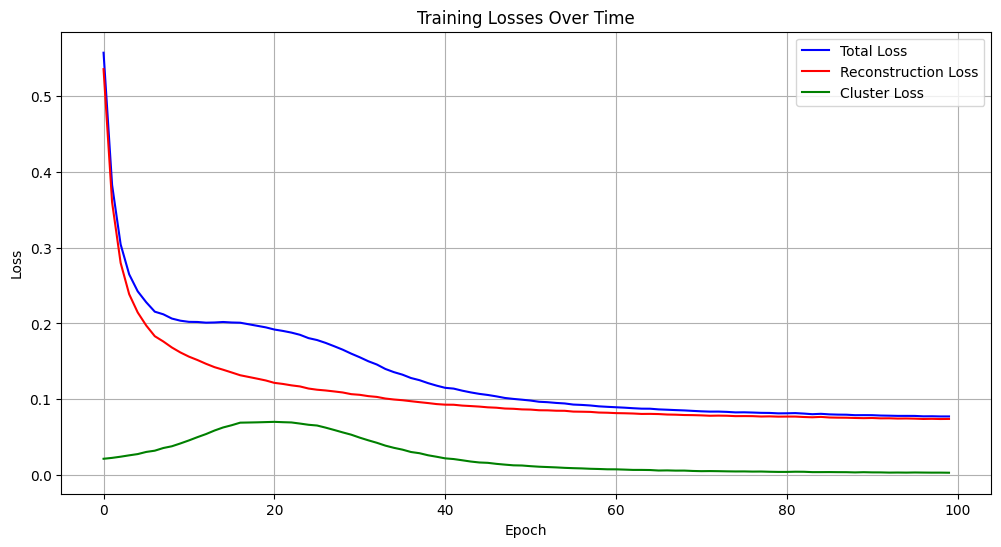

In [37]:
import matplotlib.pyplot as plt

# Plot training curves
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Total Loss', color='blue')
plt.plot(recon_losses, label='Reconstruction Loss', color='red')
plt.plot(cluster_losses, label='Cluster Loss', color='green')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses Over Time')
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig('models/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
# Load best model and get cluster assignments
best_model = DeepClusteringNetwork(
    input_dim=12,
    hidden_dims=[128, 64, 32],
    latent_dim=8,
    n_clusters=3
).to(device)

checkpoint = torch.load('models/best_model.pt')
best_model.load_state_dict(checkpoint['model_state_dict'])
best_model.eval()

# Load the complete dataset
data = pd.read_csv('../data/processed_data.csv')
X = data.drop('student_id', axis=1)  # Remove student_id column

# Get cluster assignments for all data
all_data = torch.FloatTensor(X.values).to(device)
with torch.no_grad():
    _, _, cluster_assignments = best_model(all_data)
    cluster_labels = torch.argmax(cluster_assignments, dim=1).cpu().numpy()

# Add cluster assignments to original data
data['Cluster'] = cluster_labels

# Save clustered data
data.to_csv('results/clustered_data.csv', index=False)

# Print cluster sizes
print("\nCluster Sizes:")
print(pd.Series(cluster_labels).value_counts())


Cluster Sizes:
0    5972
2    4520
1    4205
Name: count, dtype: int64


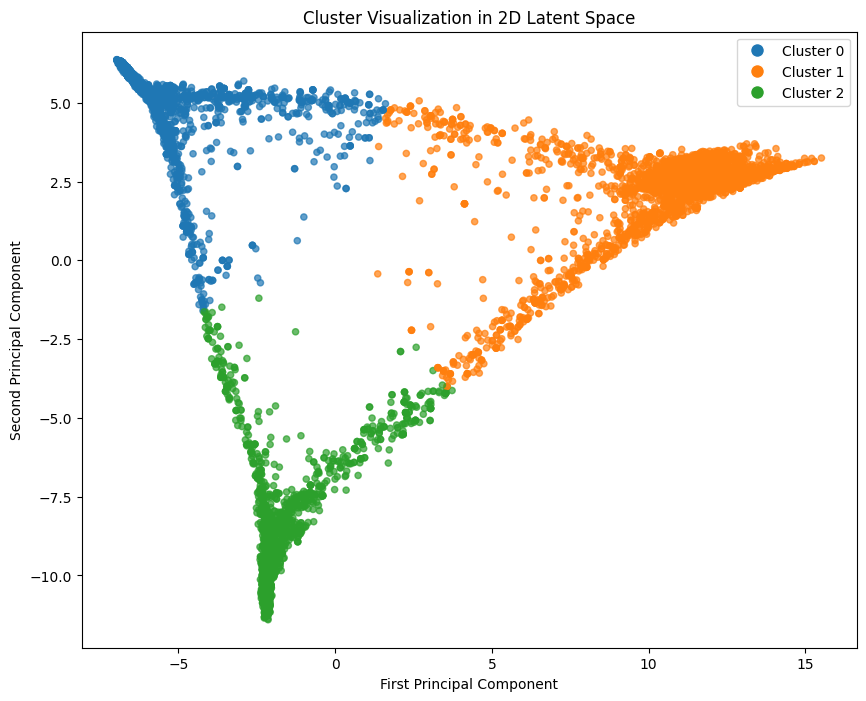

In [39]:
# Visualize clustering results using PCA
from sklearn.decomposition import PCA

# Get latent space representations
with torch.no_grad():
    _, latent_repr, _ = best_model(all_data)
    latent_repr = latent_repr.cpu().numpy()

# Apply PCA
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_repr)

plt.figure(figsize=(10, 8))
colors = [cluster_colors[label] for label in cluster_labels]
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=20, alpha=0.7)
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
                          markerfacecolor=cluster_colors[i], markersize=10) for i in cluster_colors]
plt.legend(handles=legend_elements)
plt.title('Cluster Visualization in 2D Latent Space')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.savefig('results/cluster_visualization.png')
plt.show()

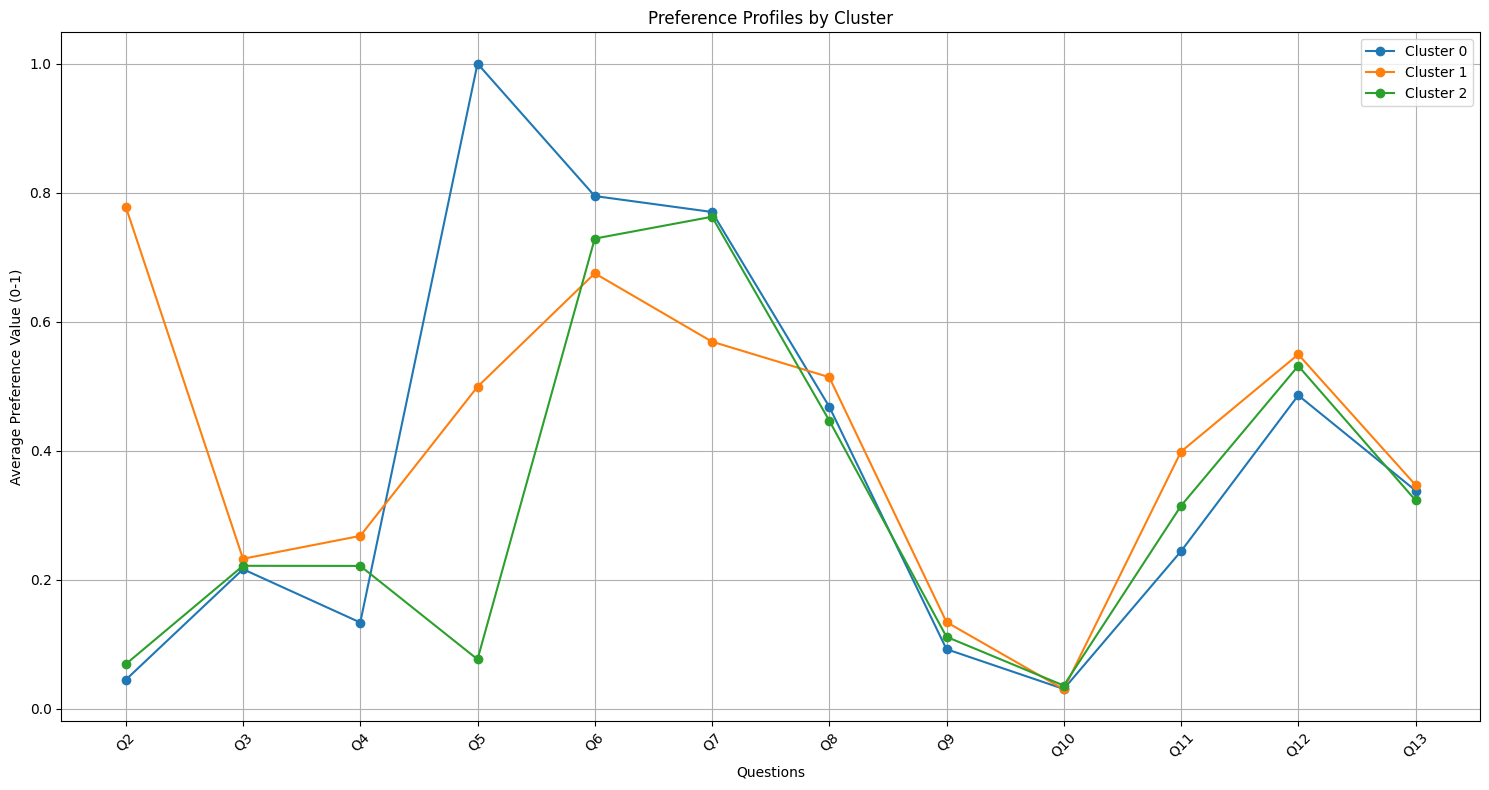

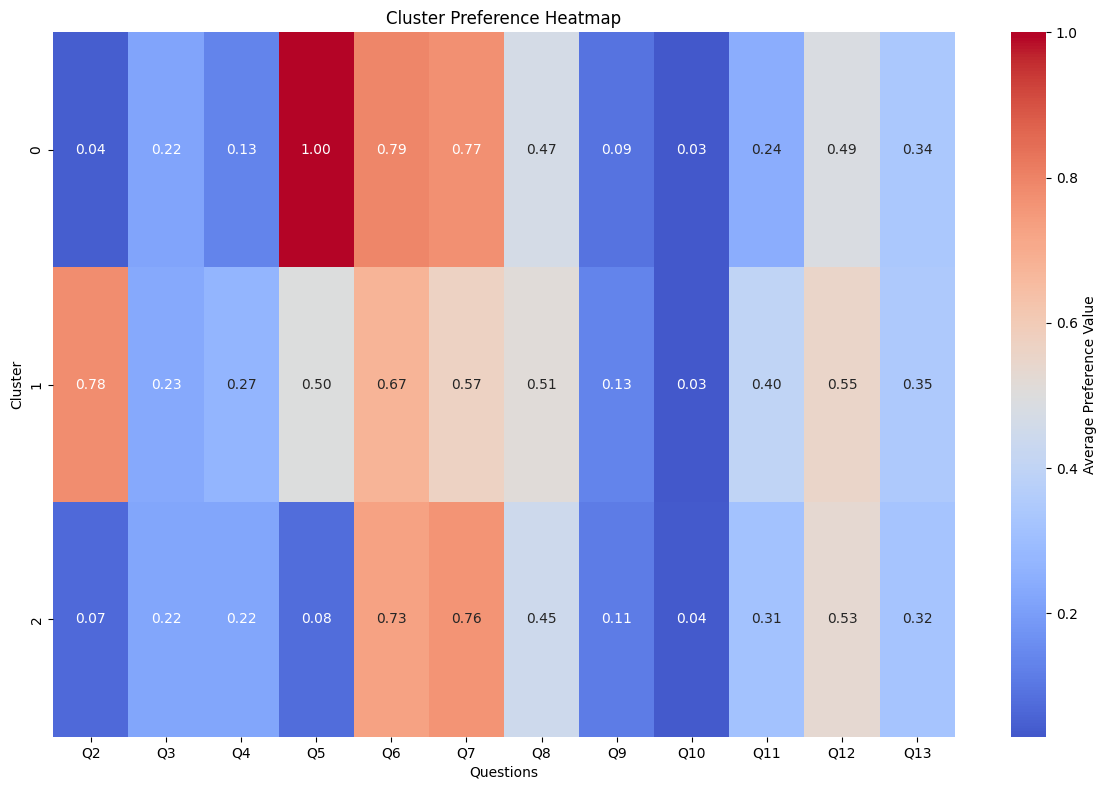

Cluster Sizes:
Cluster
0    5972
2    4520
1    4205
Name: count, dtype: int64

Cluster Averages:
            Q2     Q3     Q4     Q5     Q6     Q7     Q8     Q9    Q10    Q11  \
Cluster                                                                         
0        0.045  0.216  0.134  1.000  0.795  0.770  0.468  0.092  0.031  0.244   
1        0.778  0.232  0.268  0.499  0.675  0.569  0.514  0.134  0.030  0.398   
2        0.069  0.222  0.221  0.077  0.729  0.763  0.447  0.111  0.036  0.314   

           Q12    Q13  
Cluster                
0        0.486  0.338  
1        0.549  0.347  
2        0.531  0.323  


In [41]:
import seaborn as sns
# Load the clustered data
clustered_data = pd.read_csv('results/clustered_data.csv')

# Calculate mean preferences for each cluster, excluding student_id
feature_columns = [f'Q{i}' for i in range(2, 14)]  # Only Q2 through Q12
cluster_profiles = clustered_data.groupby('Cluster')[feature_columns].mean()

plt.figure(figsize=(15, 8))
for cluster in cluster_profiles.index:
    plt.plot(feature_columns, cluster_profiles.loc[cluster],
             marker='o', label=f'Cluster {cluster}', color=cluster_colors[cluster])
plt.xticks(rotation=45)
plt.legend()
plt.title('Preference Profiles by Cluster')
plt.xlabel('Questions')
plt.ylabel('Average Preference Value (0-1)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a heatmap of cluster differences
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profiles, cmap='coolwarm', center=0.5, 
            annot=True, fmt='.2f', cbar_kws={'label': 'Average Preference Value'})
plt.title('Cluster Preference Heatmap')
plt.ylabel('Cluster')
plt.xlabel('Questions')
plt.tight_layout()
plt.show()

# Print cluster sizes and characteristics
print("Cluster Sizes:")
print(clustered_data['Cluster'].value_counts())
print("\nCluster Averages:")
print(cluster_profiles.round(3))